# Design Single Country Nat Cat Bonds

In [2]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
import grider as grd
client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


## Perform natural hazard simulation 
### Define variables for cat bonds

In [3]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

#choose country
country = 659

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
upper_rp = 100
lower_rp = 25

### Load TC Tracks for basin

currently not needed because I incorporated it into the ex.init_TC_exp function -> still coudnt figure out how to load exisitng tc track files -> it takes forever without throwing an error

In [4]:
#storms_basin = hst.init_STORM_tracks(basins=basins, load_fls=False)

### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


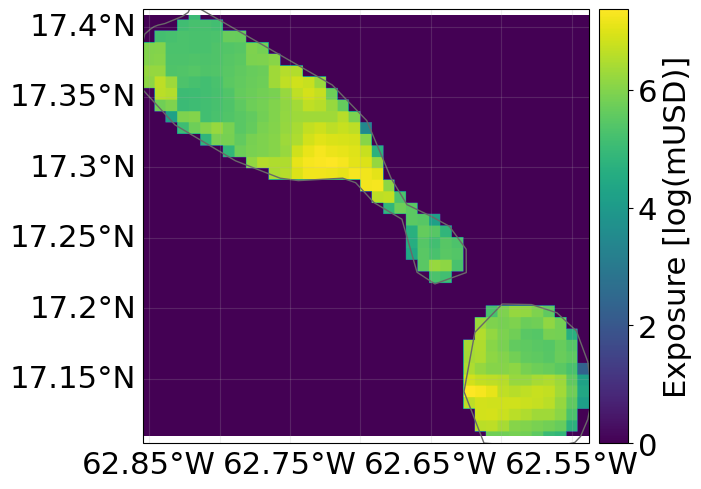

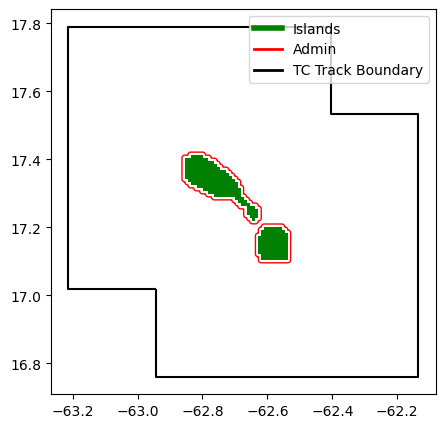

Number of tracks in NA basin: 946


In [5]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country, grid_size=60000, buffer_size=1, load_fls=True)

In [6]:
#plot filtered tc hazards
#ax_sub = storm_basin_sub.plot()
#ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\impact.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


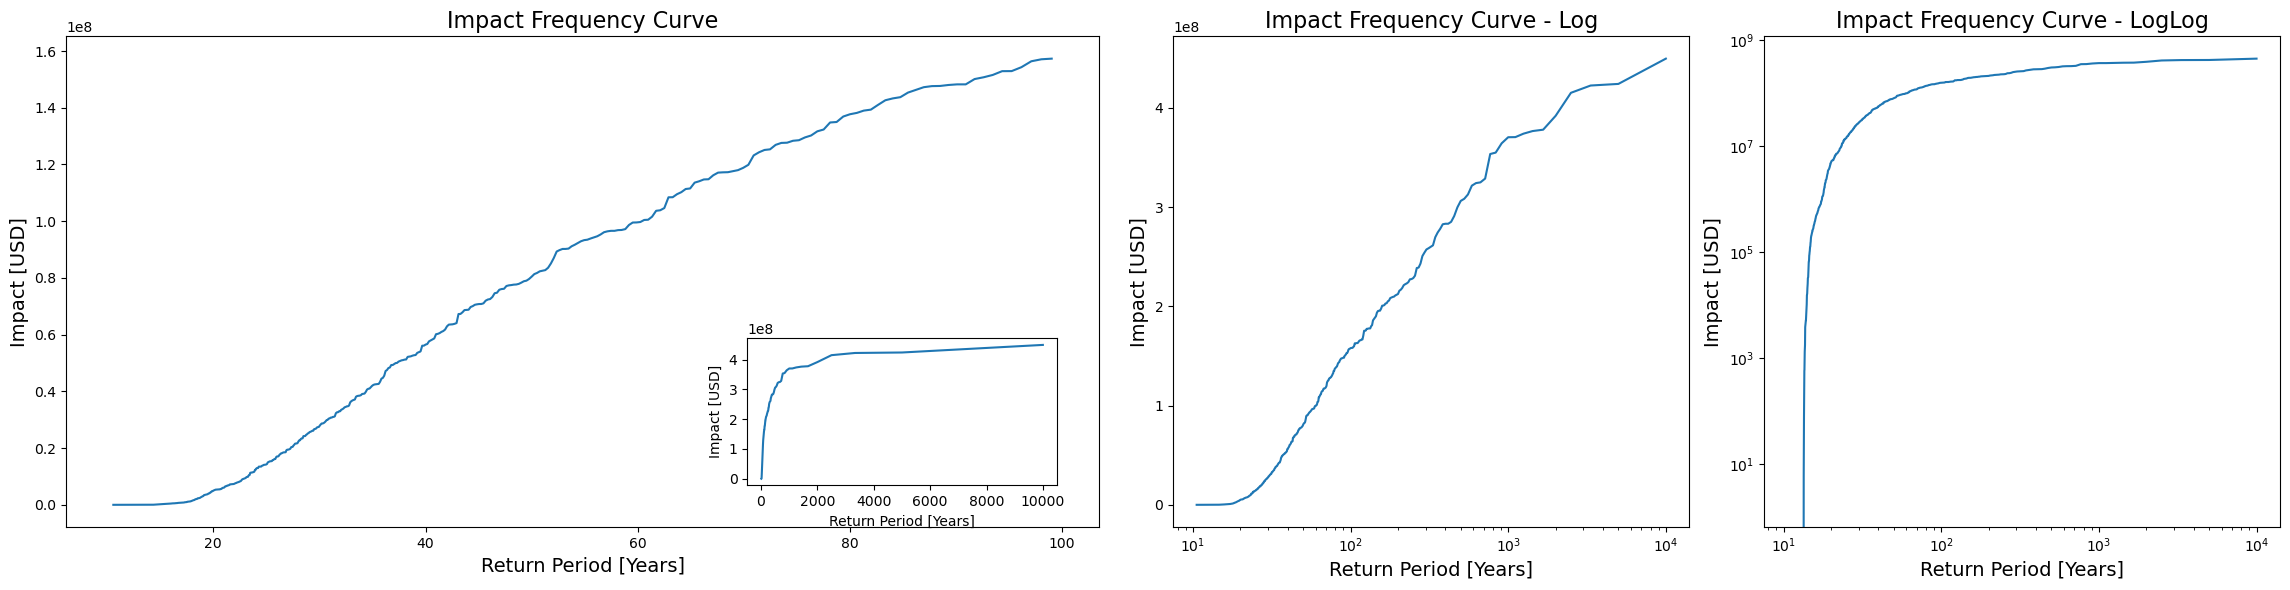

In [7]:
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf) 
imp_per_event_flt, imp_admin_evt_flt, to_protect = bpd.init_imp_flt(imp_per_event, imp_admin_evt, lower_rp)

## Optimize insurance policies

### Asses hazard intensity per event and grid cell
1. Creation of data frame which indicates the sustained wind speed per event and grid cell caclualted using a quantile or the mean across hazard centroid located in each grid cell.
2. Add year for each event.

In [8]:
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat='mean') #tc_tracks=storm_basin_sub.........tc_storms=tc_storms

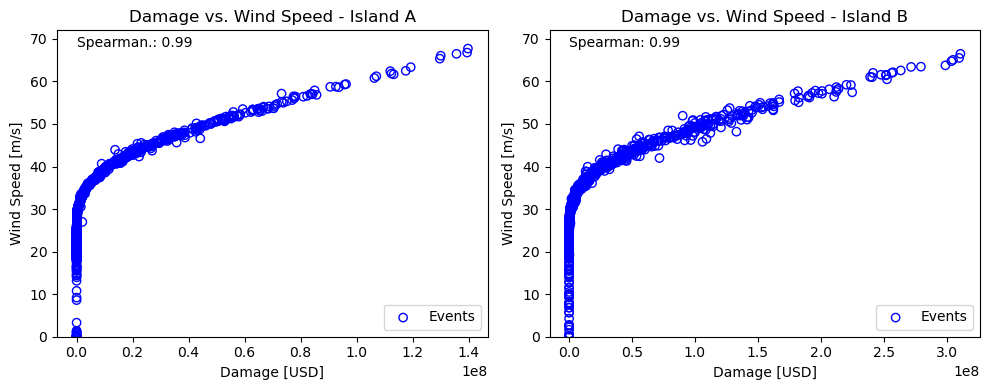

In [9]:
from scipy.stats import spearmanr

corr_a, pval = spearmanr(imp_admin_evt['A'], int_grid['A'])
corr_b, pval = spearmanr(imp_admin_evt['B'], int_grid['B'])
 
min_prot = snom.init_nominal(impact=imp, exposure=exp, prot_rp=25, print_nom=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(imp_admin_evt['A'], int_grid['A'], marker='o', edgecolor='blue', facecolor='none', label='Events')
# Add labels and title
ax1.set_title("Damage vs. Wind Speed - Island A")
ax1.set_xlabel("Damage [USD]")
ax1.set_ylabel("Wind Speed [m/s]")
ax1.text(0, 68, f'Spearman.: {round(corr_a, 2)}', fontsize = 10)
ax1.set_ylim(0,72)
ax1.legend(loc='lower right')
           
ax2.scatter(imp_admin_evt['B'], int_grid['B'], marker='o', edgecolor='blue', facecolor='none', label='Events')
# Add labels and title
ax2.set_title("Damage vs. Wind Speed - Island B")
ax2.set_xlabel("Damage [USD]")
ax2.set_ylabel("Wind Speed [m/s]")
ax2.text(0, 68, f'Spearman: {round(corr_b, 2)}', fontsize = 10)
ax2.set_ylim(0,72)
ax2.legend(loc='lower right')
# Show both plots
plt.tight_layout()
plt.show()


#### Set the nominal
Can be set in diferent ways:
1. Protecting a specified percentage of e.g. GDP
2. Protecting damages of specified return period

In [10]:
#define nominal
nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=upper_rp)

The principal of the cat bond is: 157872286.182 [USD]
Principal as share of GDP: 0.179


### Set boundarys for protected damage
1. Calculate damage return periods for grid cells
2. Set minimum damage which should be protected per grid cell
3. Adjust damage per grid and event dictionary. Damage below minimum damage should be zero. Optionally we can also set the maximum damage to the nominal, but the default is not to.

In [11]:
#rp_dam_grid, dam_rp_per_grid, imp_grid_evt_flt = bpd.init_dam_ret_per_grid(imp_grid_evt, lower_rp, adj_max=False, plt_dam_rp_grid='A')

### Perform optimization
Optmizie payout function using linear payout inbetween a minimung triggering and a maximum wind speed. Wind speeds equal or higher than maximum wind speed result in the payout of the full principle. <br>
Wind speeds are optimized for each grid cell.

In [12]:
result, optimized_step1, optimized_step2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt)

{0: (41.496350551090586, 70.88468442080742), 1: (38.578002086979794, 55.518844363316056)}


### Assess payout vs damage for each event
1. Create a payout vs damage matrix per event
2. Plot payout vs damage on 1:1 scale

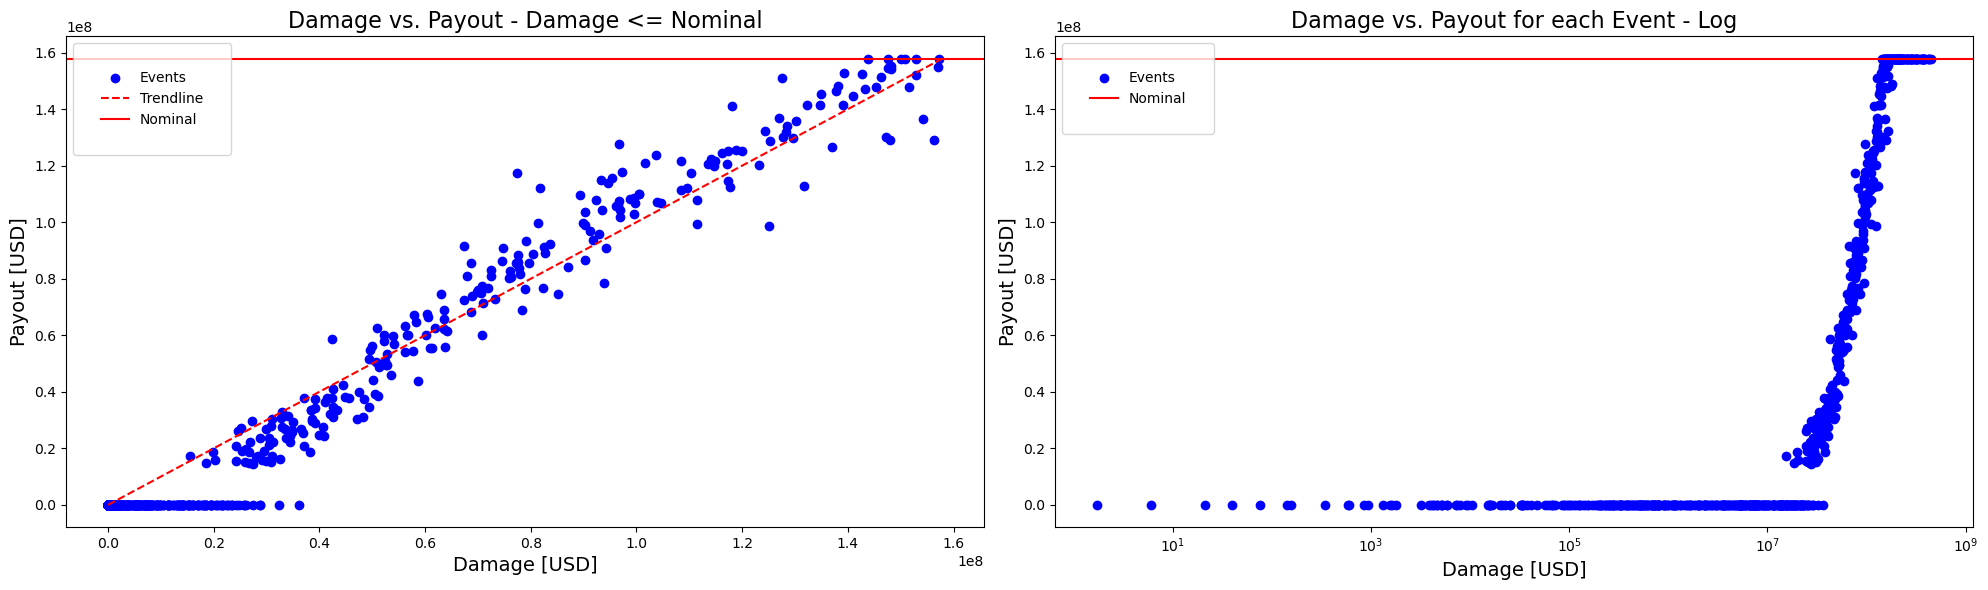

In [13]:
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_step1, optimized_step2, int_grid, nominal, imp_admin_evt, imp_per_event)

In [14]:
corr, pval = spearmanr(pay_dam_df['pay'], pay_dam_df['damage'])
 
# print the result
print("Spearman's correlation coefficient:", corr)
print(round(np.corrcoef(pay_dam_df['pay'], pay_dam_df['damage'])[0,1],2))

Spearman's correlation coefficient: 0.9566999359921318
0.92


### Calculate expected loss and attachment probability
1. Set annual probaility for hazard event
2. Simulate cat bond and calculate the expected loss as well as the annual attachment probability.

In [15]:
exp_loss_ann, att_prob, ann_losses, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal)

Expected Loss = 0.02153643570461974
Attachment Probability = 0.03384010135360405


### Calculate premiums using:
1. IBRD multiplier model
2. Most recent artemis multiplier
3. Linear regression model of Chatoro et al. 2022

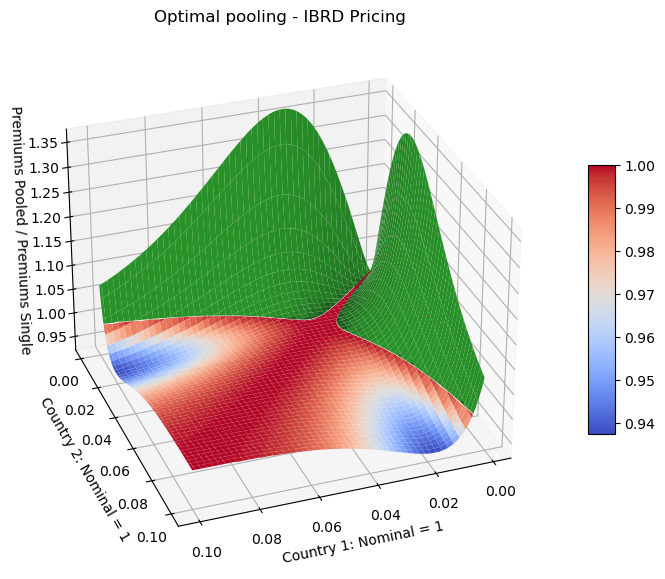

0.937 0.015700000000000006 0.1
1.367 0.001 0.035699999999998164


In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd

x_1 = np.arange(0.001, 0.1, 0.0001)
x_2 = np.arange(0.1, 0.0009999, -0.0001)
n_1 = 1
n_2 = 1

# Create meshgrid for x_1 and x_2
X1, X2 = np.meshgrid(x_1, x_2)
F = np.zeros(X1.shape)

# Calculate values of f for each pair of x_1 and x_2
for i in range(len(x_1)):
    for j in range(len(x_2)):
        n_3 = n_1 + n_2
        x_3 = (X1[j, i] * n_1 + X2[j, i] * n_2) / n_3
        xn_1 = float(prib.monoExp(X1[j, i]*100, a, k, b)) * X1[j, i] * n_1
        xn_2 = float(prib.monoExp(X2[j, i]*100, a, k, b)) * X2[j, i] * n_2
        xn_sng = xn_1 + xn_2
        xn_3 = round(float(prib.monoExp(x_3*100, a, k, b)), 7) * x_3 * n_3
        cur = xn_3 / xn_sng 
        F[j, i] = round(xn_3 / xn_sng, 3)

        #if cur <= 1.5:
        #    F[j, i] = round(cur,10)
        #else: 
        #    F[j, i] = round(cur,10)

F_good = np.where(F <= 1, F, np.nan)  # Good values
F_bad = np.where(F > 1, F, np.nan)    # Bad values

# Plotting the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use a color map that emphasizes the minima
#surf = ax.plot_surface(X1, X2, F, cmap='coolwarm', edgecolor='none')
surf = ax.plot_surface(X1, X2, F_good, cmap='coolwarm', edgecolor='none')
surf2 = ax.plot_surface(X1, X2, F_bad, color='tab:green', edgecolor='none')

# Add contour lines to better highlight areas with low values
ax.contourf(X1, X2, F, zdir='z', offset=-100, cmap='coolwarm')
ax.contourf(X1, X2, F, zdir='x', offset=-40, cmap='coolwarm')
ax.contourf(X1, X2, F, zdir='y', offset=40, cmap='coolwarm')

# Zoom in on the z-axis to focus on minimal values
#ax.set_zlim(np.min(F), np.percentile(F, 99))  # Use the 95th percentile to avoid extreme values

# Adjust the viewing angle to better see the minima
ax.view_init(elev=30, azim=70)

# Add color bar for reference
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel(f'Country 1: Nominal = {n_1}')
ax.set_ylabel(f'Country 2: Nominal = {n_2}')
ax.set_zlabel('Premiums Pooled / Premiums Single')
ax.set_title('Optimal pooling - IBRD Pricing')

plt.show()

# Find the minimum of F and its corresponding (x1, x2) values
min_F = np.nanmin(F)
min_F_index = np.unravel_index(np.nanargmin(F), F.shape)
min_x1 = X1[min_F_index]
min_x2 = X2[min_F_index]

print(min_F, min_x1, min_x2)

max_F = np.nanmax(F)
max_F_index = np.unravel_index(np.nanargmax(F), F.shape)
max_x1 = X1[max_F_index]
max_x2 = X2[max_F_index]

print(max_F, max_x1, max_x2)



In [17]:
losses = ann_losses['losses']
print(losses[0])

[0.0]


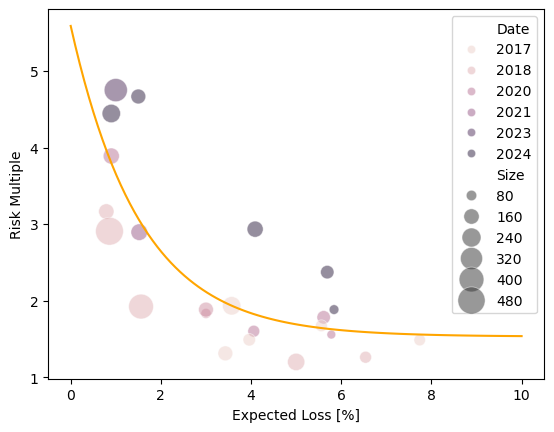

The premium based on past IBRD bonds is 5.47%, 8634830.0USD, 0.977%
The premium based on the artemis multiplier is 8.851%, 13974026.0USD, 1.581%
The premium based on the regression model from Chatoro et al. 2022 is 7.301%, 11526453.0USD, 1.304%
The premium based on required sharpe ration of 0.5 is 9.448%, 14915584.0USD, 1.687%


In [27]:
params_ibrd = prib.init_prem_ibrd()
a, k, b = params_ibrd
artemis_multiplier = 4.11
target_sharpe = 0.5
rf_rate = 0.05
tot_exp = exp.gdf['value'].sum()

premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
premium_artemis = exp_loss_ann * artemis_multiplier
premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100
premium_sharpe = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)

print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%, {round(premium_ibrd*nominal,0)}USD, {round(premium_ibrd*nominal/tot_exp*100,3)}%')
print(f'The premium based on the artemis multiplier is {round(premium_artemis*100, 3)}%, {round(premium_artemis*nominal,0)}USD, {round(premium_artemis*nominal/tot_exp*100,3)}%')
print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%, {round(premium_regression*nominal,0)}USD, {round(premium_regression*nominal/tot_exp*100,3)}%')
print(f'The premium based on required sharpe ration of {target_sharpe} is {round(premium_sharpe*100, 3)}%, {round(premium_sharpe*nominal,0)}USD, {round(premium_sharpe*nominal/tot_exp*100,3)}%')

### Calculate cat bond metrics
1. Perform Monte-Carlo Simulation
2. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

### Simulate a 3-year cat bond

In [28]:
#requ_prem = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)
premium_simulation, returns = sb.init_bond_simulation(pay_dam_df, premium_sharpe, rf_rate, nominal) 

In [151]:
print(premium_simulation['Average Payments']/tot_exp)

0    0.116655
Name: Average Payments, dtype: object


In [152]:
high_yield_bond = pd.read_excel('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/3_m_treasury.xlsx')
mean_hy = high_yield_bond['Return'].mean()
risk_free_hy = high_yield_bond['Risk free'].mean()
std_hy = high_yield_bond['Return'].std()
ES_95_hy = es_metrics['ES_95_ann']
ES_99_hy = es_metrics['ES_99_ann']
sharpe_hy = (mean_hy - risk_free_hy) / std_hy
cond_sharpe_hy_99 = (mean_hy - risk_free_hy) / ES_99_hy
cond_sharpe_hy_95 = (mean_hy - risk_free_hy) / ES_95_hy

print('High yield bond sharpe ratio: ', sharpe_hy)
print('High yield bond conditional sharpe ratio (0.99): ', cond_sharpe_hy_99)
print('High yield bond conditional sharpe ratio (0.95): ', cond_sharpe_hy_95)

#p = requ_premiumsn
#premium_simulation_p, returns_p = sb.init_bond_simulation(pay_dam_df, p, rf_rates, nominal) #simulate cat bond using a Monte Carlo simulation
#print('Nat cat bond sharpe ratio: ', premium_simulation_p['Sharpe_ratio_ann'][0])
#print('Nat cat bond conditional sharpe ratio (0.01): ', premium_simulation_p['Cond_sharpe_ratio_01'][0])
#print('Nat cat bond conditional sharpe ratio (0.05): ', premium_simulation_p['Cond_sharpe_ratio_05'][0])

High yield bond sharpe ratio:  0.4230329028471114
High yield bond conditional sharpe ratio (0.99):  5.914652532318806
High yield bond conditional sharpe ratio (0.95):  9.282656260976822


## Perform cat bond simulation using different nominals

In [154]:
#define nominals
prot_share_arr = np.arange(0.02, 0.51, 0.03) #protected share of total exposure
arr_nominal = []

for prot_share in prot_share_arr:
    nominal = snom.init_nominal(impact=imp, exposure=exp, prot_share=prot_share, print_nom=False)
    arr_nominal.append(nominal)

print('Nominals calculated')

#optimize payout per grid for each nominal
optimized_xs_nom = {}
optimized_ys_nom = {}
result_nom = {}
pay_dam_df_nom = {}
exp_loss_ann_nom = {}
att_prob_nom = {}
premium_ibrd = {}
premium_artemis = {}
premium_regression = {}
premium_simulation = {}
returns = {}
premium_simulation_ibrd = {}
returns_ibrd = {}
premium_simulation_artemis = {}
returns_artemis = {}
premium_simulation_regression = {}
returns_regression = {}
requ_premiums_mod = {}
requ_premiums_high = {}
ann_losses = {}
requ_prem =  {}

for nom in arr_nominal:
    nom_str = str(round(nom,0))
    result_nom[nom_str], optimized_xs_nom[nom_str], optimized_ys_nom[nom_str] = apo.init_alt_optimization(int_grid, nom, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt, print_params=False)

    pay_dam_df_nom[nom_str] = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_xs_nom[nom_str], optimized_ys_nom[nom_str], int_grid, nom, imp_admin_evt)
    
    exp_loss_ann_nom[nom_str], att_prob_nom[nom_str], ann_losses[nom_str], es_metrics[nom_str] = sb.init_exp_loss_att_prob_simulation(pay_dam_df_nom[nom_str], nom, print_prob=False)

    premium_ibrd[nom_str] = prib.monoExp(exp_loss_ann_nom[nom_str] * 100, a, k, b) * exp_loss_ann_nom[nom_str]
    premium_artemis[nom_str] = exp_loss_ann_nom[nom_str] * artemis_multiplier
    premium_regression[nom_str] = cp.calc_premium_regression(exp_loss_ann_nom[nom_str] * 100) / 100
    
    premium_simulation_ibrd[nom_str], returns_ibrd[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_ibrd[nom_str], rf_rate, nom) 
    premium_simulation_artemis[nom_str], returns_artemis[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_artemis[nom_str], rf_rate, nom) 
    premium_simulation_regression[nom_str], returns_regression[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_regression[nom_str], rf_rate, nom) 
    requ_prem[nom_str] = sb.init_prem_sharpe_ratio(ann_losses[nom_str], rf_rate, target_sharpe)
    premium_simulation[nom_str], returns[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], requ_prem[nom_str], rf_rate, nom)
    

Nominals calculated


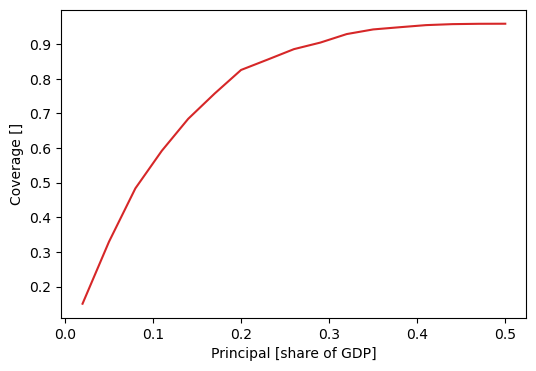

In [157]:
coverage_nom = []
basis_risk_nom = []
tot_pay_nom = []
tot_pay_gdp = []
std_nom = []

for nom_it in arr_nominal:
    nom_str = str(round(nom_it,0))
    coverage_nom.append(premium_simulation[nom_str]['Coverage'])
    basis_risk_nom.append((premium_simulation[nom_str]['Basis_risk'])*-1/nom_it)
    tot_pay_nom.append((premium_simulation[nom_str]['Average Payments'])/(nominal))
    tot_pay_gdp.append((premium_simulation[nom_str]['Average Payments'])/(nominal/prot_share))
    #std = np.std(ann_losses[nom_str])
    #std_nom.append(std)

fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:red'
ax1.plot(prot_share_arr, coverage_nom, color=color)
ax1.set_xlabel('Principal [share of GDP]')
ax1.set_ylabel('Coverage []')
#ax1.tick_params(axis='y', labelcolor=color)

#ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
#color = 'tab:blue'
#ax2.set_ylabel('Basis Risk [USD]', color=color)  # we already handled the x-label with ax1
#ax2.plot(prot_share_arr, basis_risk_nom, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



plot premium vs coverage. How much do I need to pay for a certain coverage. Also include what a certain coverage would mean money wise for the country -> how much is paid relative to gdp

Think about other coverage metrics -> compare them.

What is good benchmark metric?

Cost-benefit with premium plot.

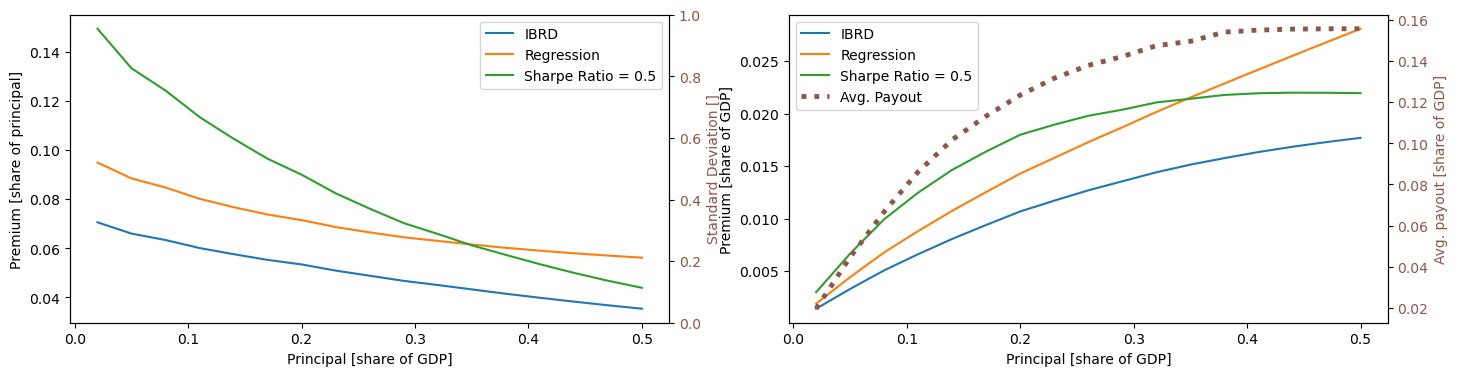

In [160]:

#requ_premiums_arr = np.array(fct.get_all_values(requ_prem))
premium_artemis_arr = np.array(fct.get_all_values(premium_artemis))
premium_ibrd_arr = np.array(fct.get_all_values(premium_ibrd))
premium_regression_arr = np.array(fct.get_all_values(premium_regression))
premium_required_arr = np.array(fct.get_all_values(requ_prem))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 4))

#ax1.plot(prot_share_arr, premium_artemis.values(), label='Artemis')
ax1.plot(prot_share_arr, premium_ibrd.values(), label='IBRD')
ax1.plot(prot_share_arr, premium_regression.values(), label='Regression')
ax1.plot(prot_share_arr, requ_prem.values(), label='Sharpe Ratio = 0.5')
ax1.set_xlabel('Principal [share of GDP]')
ax1.set_ylabel('Premium [share of principal]')
ax1.tick_params(axis='y')
#ax1.set_ylim(0,np.max(std_nom)+0.01)


ax1_1 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:brown'
ax1_1.set_ylabel('Standard Deviation []', color=color)  # we already handled the x-label with ax1
#ax1_1.plot(prot_share_arr, std_nom, color=color, linewidth=3.5, linestyle='dotted', label='Std(Losses)')
ax1_1.tick_params(axis='y', labelcolor=color)
#ax1_1.set_ylim(0,np.max(std_nom)+0.01)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax1_1.get_legend_handles_labels()  
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

color = 'tab:red'
#ax2.plot(prot_share_arr, (premium_artemis_arr * arr_nominal)*3 / (nominal/prot_share), label='Artemis')
ax2.plot(prot_share_arr, (premium_ibrd_arr * arr_nominal) / (nominal/prot_share), label='IBRD')
ax2.plot(prot_share_arr, (premium_regression_arr * arr_nominal) / (nominal/prot_share), label='Regression')
ax2.plot(prot_share_arr, (premium_required_arr * arr_nominal) / (nominal/prot_share), label='Sharpe Ratio = 0.5')
ax2.set_xlabel('Principal [share of GDP]')
ax2.set_ylabel('Premium [share of GDP]')
ax2.tick_params(axis='y')

ax3 = ax2.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:brown'
ax3.set_ylabel('Avg. payout [share of GDP]', color=color)  # we already handled the x-label with ax1
ax3.plot(prot_share_arr, tot_pay_gdp, color=color, linewidth=3.5, linestyle='dotted', label='Avg. Payout')
ax3.tick_params(axis='y', labelcolor=color)


lines1, labels1 = ax2.get_legend_handles_labels()  
lines2, labels2 = ax3.get_legend_handles_labels()  
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

What sharpe ratio do the calculated premiums imply.

Why do the curves behave like they do? -> make comments

Check on stop payment if payout happpens.

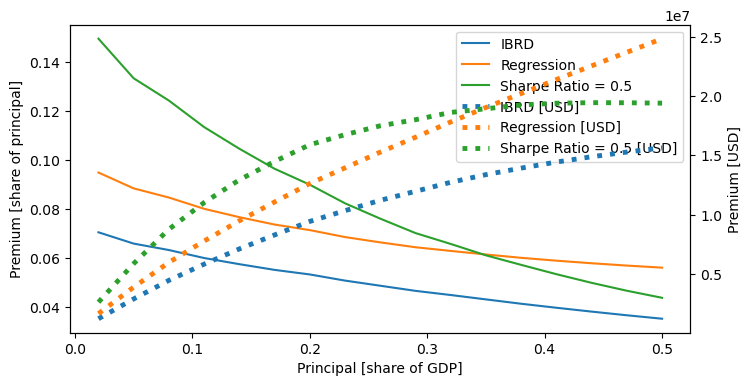

In [161]:
fig, ax1 = plt.subplots(figsize=(8, 4))

#ax1.plot(prot_share_arr, premium_artemis.values(), label='Artemis')
ax1.plot(prot_share_arr, premium_ibrd.values(), label='IBRD')
ax1.plot(prot_share_arr, premium_regression.values(), label='Regression')
ax1.plot(prot_share_arr, requ_prem.values(), label='Sharpe Ratio = 0.5')
ax1.set_xlabel('Principal [share of GDP]')
ax1.set_ylabel('Premium [share of principal]')
ax1.tick_params(axis='y')


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:brown'
ax2.set_ylabel('Premium [USD]')  # we already handled the x-label with ax1
ax2.plot(prot_share_arr, (premium_ibrd_arr * arr_nominal), label='IBRD [USD]', linewidth=3.5, linestyle='dotted')
ax2.plot(prot_share_arr, (premium_regression_arr * arr_nominal), label='Regression [USD]', linewidth=3.5, linestyle='dotted')
ax2.plot(prot_share_arr, (premium_required_arr * arr_nominal), label='Sharpe Ratio = 0.5 [USD]', linewidth=3.5, linestyle='dotted')

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax2.get_legend_handles_labels()  
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

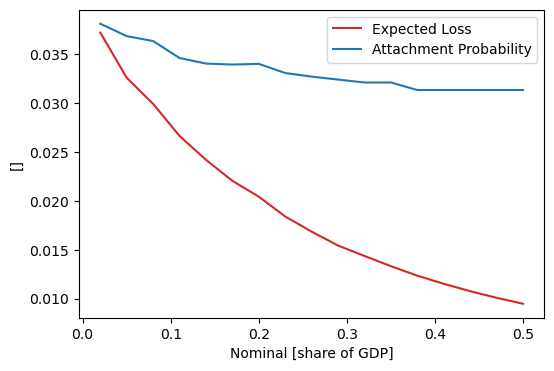

In [162]:
exp_loss_arr = np.array(fct.get_all_values(exp_loss_ann_nom))
att_prob_arr = np.array(fct.get_all_values(att_prob_nom))

fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:red'
ax1.plot(prot_share_arr, exp_loss_arr, color=color, label='Expected Loss')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('[]')

color = 'tab:blue'
ax1.plot(prot_share_arr, att_prob_arr, color=color, label='Attachment Probability')

plt.legend()
plt.show()

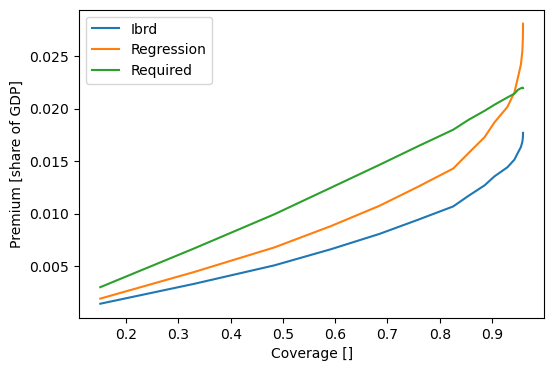

In [168]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(coverage_nom, premium_ibrd_arr*arr_nominal/tot_exp, label='Ibrd')
ax1.plot(coverage_nom, premium_regression_arr*arr_nominal/tot_exp, label='Regression')
ax1.plot(coverage_nom, premium_required_arr*arr_nominal/tot_exp, label='Required')
ax1.set_xlabel('Coverage []')
ax1.set_ylabel('Premium [share of GDP]')


plt.legend()
plt.show()

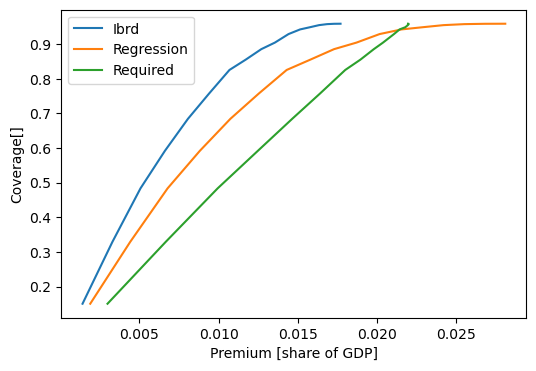

In [170]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(premium_ibrd_arr*arr_nominal/tot_exp, coverage_nom, label='Ibrd')
ax1.plot(premium_regression_arr*arr_nominal/tot_exp, coverage_nom, label='Regression')
ax1.plot(premium_required_arr*arr_nominal/tot_exp, coverage_nom, label='Required')
ax1.set_xlabel('Premium [share of GDP]')
ax1.set_ylabel('Coverage []')


plt.legend()
plt.show()

In [22]:
premium_simulation_cond = {}
returns_cond = {}
for nom in arr_nominal:
    nom_str = str(nom)
    premium_simulation_cond[nom_str], returns_cond[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], requ_prem[nom_str], rf_rate, nom) #simulate cat bond using a Monte Carlo simulation

cond_shp_rat_01 = []
cond_shp_rat_05 = []
for nom in arr_nominal:
    nom_str = str(nom)
    cond_shp_rat_01.append(premium_simulation_cond[nom_str]['Cond_sharpe_ratio_01'][0])
    cond_shp_rat_05.append(premium_simulation_cond[nom_str]['Cond_sharpe_ratio_05'][0])

KeyError: 'Cond_sharpe_ratio_01'

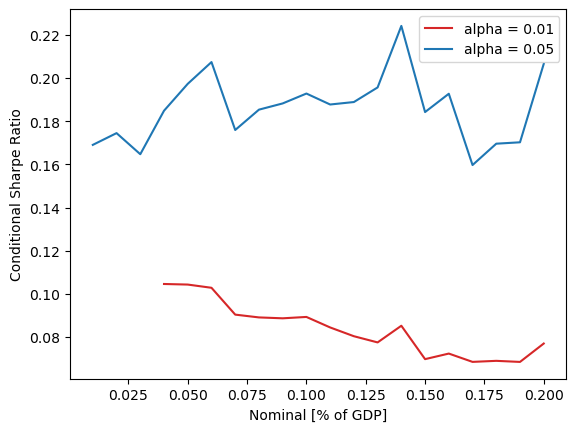

In [41]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(prot_share_arr, cond_shp_rat_01, color=color, label='alpha = 0.01')
ax1.set_xlabel('Nominal [% of GDP]')
ax1.set_ylabel('Conditional Sharpe Ratio')

color = 'tab:blue'
ax1.plot(prot_share_arr, cond_shp_rat_05, color=color, label='alpha = 0.05')

plt.legend()
plt.show()

splitting premiums according to share of single country regarding total of expected shortfall (if this is the driver of pricing)

For a given nominal what premium do I have to pay?

For a given premium how much can I increase the coverage?

Look at cost benefits

In [28]:
import dill
dill.dump_session('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/sessions/sng_bond.db')